In [1]:
# Only needed in a Jupyter Notebook
%matplotlib inline
# Optional plot styling
import matplotlib
matplotlib.style.use('bmh')

In [2]:
import matplotlib.pyplot as plt
from pycalphad import equilibrium
from pycalphad import Database, Model
import pycalphad.variables as v
import numpy as np

In [3]:
db = Database('alfe_sei.TDB')
my_phases = list(set(db.phases.keys()) - {'BCC_A2'})

In [4]:
eq = equilibrium(db, ['AL', 'FE', 'VA'], my_phases, {v.X('AL'): (0, 1, 0.01), v.T: (300, 2000, 10), v.P: 101325},
                 output=['heat_capacity', 'degree_of_ordering', 'curie_temperature'], _approx=True)
print(eq)

<xarray.Dataset>
Dimensions:             (P: 1, T: 170, X_AL: 100, component: 2, internal_dof: 5, vertex: 2)
Coordinates:
  * P                   (P) float64 1.013e+05
  * T                   (T) float64 300.0 310.0 320.0 330.0 340.0 350.0 ...
  * X_AL                (X_AL) float64 1e-09 0.01 0.02 0.03 0.04 0.05 0.06 ...
  * vertex              (vertex) int64 0 1
  * component           (component) object 'AL' 'FE'
  * internal_dof        (internal_dof) int64 0 1 2 3 4
Data variables:
    MU                  (P, T, X_AL, component) float64 -1.568e+05 ...
    NP                  (P, T, X_AL, vertex) float64 1.0 nan 1.0 nan 1.0 nan ...
    GM                  (P, T, X_AL) float64 -8.185e+03 -9.284e+03 ...
    X                   (P, T, X_AL, vertex, component) float64 1.092e-09 ...
    Y                   (P, T, X_AL, vertex, internal_dof) float64 1.092e-09 ...
    Phase               (P, T, X_AL, vertex) object 'B2_BCC' '' 'B2_BCC' '' ...
    curie_temperature   (P, T, X_AL) float64 1.0

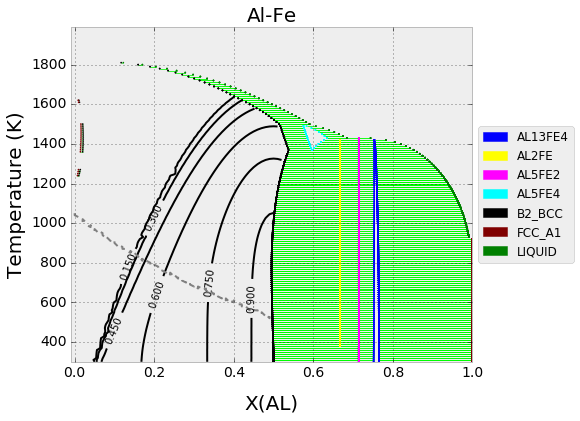

In [12]:
from pycalphad import eqplot
fig = plt.figure(figsize=(9,6))
eqplot(eq, ax=fig.gca())
tc_indices = np.logical_and(np.abs(eq['curie_temperature'].values - eq['T'].values[..., None]) < 10,
                            np.any(eq.Phase.values == 'B2_BCC', axis=-1))
tc_indices = np.nonzero(np.logical_and(tc_indices, np.sum(eq.Phase.values != '', axis=-1, dtype=np.int) == 1))
bcc_indices = np.logical_and(np.any(eq.Phase.values == 'B2_BCC', axis=-1),
                                    np.sum(eq.Phase.values != '', axis=-1, dtype=np.int) == 1)
tc_arr = np.array([eq['X'].sel(component='AL', vertex=0).values[tc_indices], np.take(eq['T'].values, tc_indices[1])])
tc_arr = tc_arr[:, tc_arr[0].argsort()]
fig.gca().plot(tc_arr[0], tc_arr[1], '--', color='grey', linewidth=2)
X, Y = np.meshgrid(eq['X_AL'].values, eq['T'].values)
CS = fig.gca().contour(X, Y, np.squeeze(np.ma.array(eq['degree_of_ordering'].sel(vertex=0).values, mask=~bcc_indices)), colors='k')
fig.gca().clabel(CS, inline=1, fontsize=10)
plt.show()